# V.1 Exploring the green reds

# a) Write a function that will plot a scatterplot matrix

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")
    # Convert dataframe value to array
    data = df.values
    # get data & variable number
    numdata, numvar = data.shape

    # output two objects, whole plot fig and a set of subplot axes 
    fig, axes = plt.subplots(nrows=numvar, ncols=numvar, figsize=(24,24))
    # close space between subplot
    fig.subplots_adjust(hspace=0, wspace=0)

    # Hide all ticks and labels
    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    # upper triangle coordinate
    tri_upper = []
    for row in range(numvar):
        for col in range(row + 1, numvar):
            tri_upper.append([row, col])

    # change quality value to color list
    cq = []
    for i in range(numdata):
        if (df['quality'].values[i] >= good_threshold):
            cq.append('green')
        elif (df['quality'].values[i] <= bad_threshold):
            cq.append('red')
        else:
            cq.append('none')
        
    # Plot the data
    for i, j in tri_upper:
        for x, y in [(i,j), (j, i)]:
            axes[x,y].scatter(data[:,y % numvar], data[:,x % numvar], s=3, c=cq)

    # Label the diagonal subplots...
    names = df.columns.values
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center', size=12)

    # show fig
    fig.show()
    if (save_plot == True):
        fig.savefig('scatter_matrix.png')

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


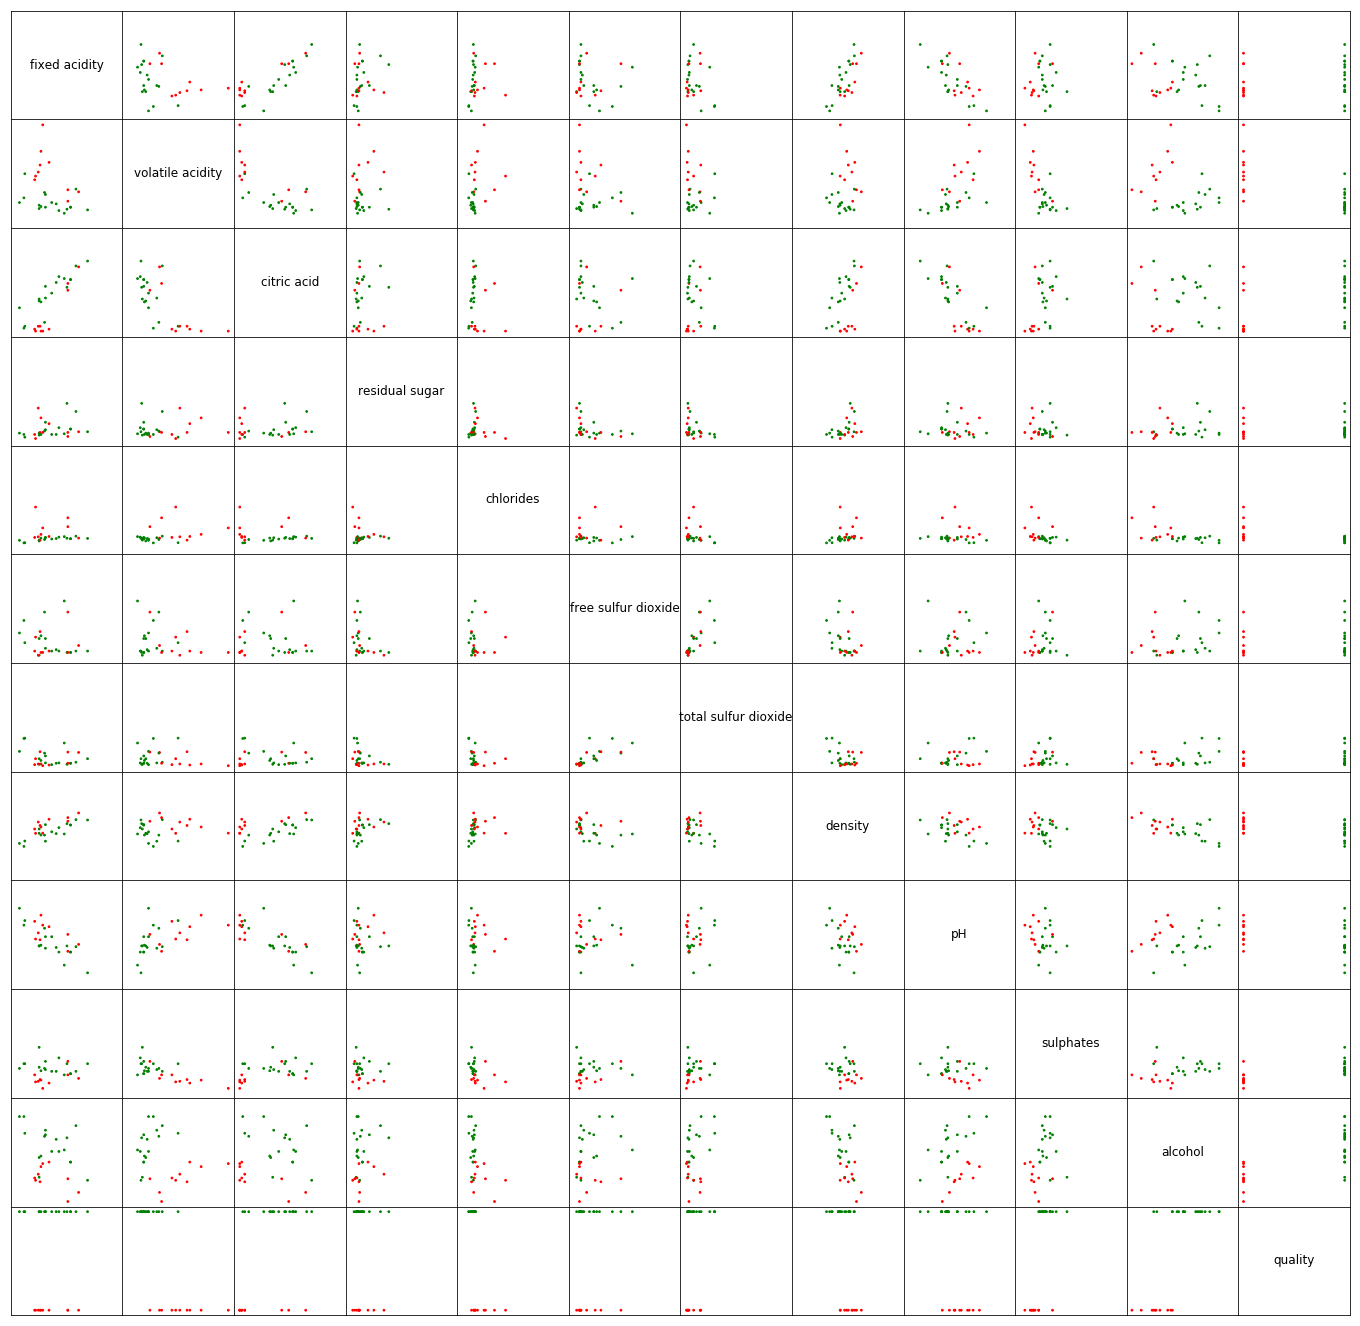

In [3]:
plot_scatter_matrix('winequality-red.csv', 8, 3, True)

# Referance

Basic Panda: https://ithelp.ithome.com.tw/articles/10191588<br>
make scattorplot matrix: https://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib<br>
zip() in GeeksforGeeks: https://www.geeksforgeeks.org/zip-in-python/<br>
save plot: https://pythonspot.com/matplotlib-save-figure-to-image-file/<br>

## Doc

matplotlib.pyplot.scatter: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter<br>
matplotlib.pyplot.subplots: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html<br> matplotlib.figure.Figure: https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html<br>
numpy.triu_indices_from: https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu_indices_from.html<br>
matplotlib.pyplot.annotate: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html<br>

# b)  Question:
Now that you’ve had a chance to analyze different chemical factors in red wines and their relationship with high scores (8 or higher) and low scores (3 or lower), which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

# Answer:
I assume if the factors can be seperate good and bad by eyes, that's a useful factor to distinguish wine quality.<br>
<br>
My observation as follow:<br>
pH & alcohol / alcohol & volatile acidity / density & citric acid<br>

# V.2 Learning to perceptron

## a) & b) Perceptron Implementation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys
import math

In [4]:
def build_data(wine_data, factor1, factor2, good_thresh, bad_thresh):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")
    # Only catch data over or below threshold
    for i in range(len(df)):
        if (df.loc[i, 'quality'] < good_thresh and df.loc[i, 'quality'] > bad_thresh):
            df = df.drop([i])
    # build dataFrame
    df = df[[factor1, factor2]]
    return df
    
def build_target(wine_data, good_thresh, bad_thresh, value=[1, 0]):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")
    # Only catch data over or below threshold, and transfer to 1 & 0
    for i in range(len(df)):
        if (df.loc[i, 'quality'] >= good_thresh):
            df.loc[i, 'quality'] = value[0]
        elif (df.loc[i, 'quality'] <= bad_thresh):
            df.loc[i, 'quality'] = value[1]
        else:
            df = df.drop([i])
    # build dataFrame
    target = pd.DataFrame(df['quality'].values, columns=['target'])    
    return (target)

In [5]:
class ANN: 
    def ft_dataTDotError(self, data, error):
        size = data.shape[0]
        re = [0 for i in range(size)]
        for i in range(size):
            re[i] = self.getNetValue(data[i], error)
        return pd.DataFrame([re]).values[0]
    
    def getNetValue(self, s1, s2):
        net = 0;
        for i in range(len(s1)):
            net += s1[i] * s2[i]
        return net

    def ft_transpose(self, m1):
        df = pd.DataFrame(m1)
        new = []
        for col in range(m1.shape[1]):
            new.append(df.iloc[:, col].values)
        return pd.DataFrame(new).values

In [6]:
class Perceptron(ANN):
    def __init__(self, lr, epoch):
        ANN.__init__(self)
        self.lr = lr
        if (epoch <= 0):
            epoch = sys.maxsize
        self.epoch = epoch
        
    def train(self, data, target, verbose = True):
        curEpoch = 0
        performance = []
        self.weight = [random.uniform(-1, 1) for i in range(data.shape[1] + 1)]
        # Start training
        for _ in range(self.epoch):
            epochError = 0
            # Update weight
            for xi, yi in zip(data, target):
                deltaW = self.lr * (yi - self.predict(xi))
                self.weight[0] += deltaW
                self.weight[1:] += deltaW * xi
                epochError += int(deltaW != 0.0)
            # record performance
            curEpoch += 1
            performance.append((curEpoch, epochError, self.weight))
            if (verbose == True):
                print(f"Training preceptron, curEpoch: {curEpoch}, errorNumber: {epochError}")
            if (self.epoch == sys.maxsize and epochError <= 0):
                break
        return performance

    def predict(self, x):
        return 1 if self.activation(x) >= 0.0 else 0
    
    def activation(self, x):
        return self.getNetValue(self.weight[1:], x) + self.weight[0]

## c) Generate performance plot

In [7]:
def draw_number_of_errors(ax, performance, epoch):
    # epoch error check
    if (epoch == -1):
        epoch = len(performance)
    
    # set scatter plot x and y
    er = []
    ep = []
    for i in range(epoch):
        ep.append(performance[i][0])
        er.append(performance[i][1])
    
    # draw scatter plot
    ax[0].plot(ep, er, label='Errors as a function of epoch')
    ax[0].set(xlabel='Epoch', ylabel='Error')
    ax[0].set_title('Errors as a function of epochs')

def draw_decision_boundary(ax, data, performance, epoch):
    # set boundary
    x_min = data.iloc[:,0].min()
    x_max = data.iloc[:,0].max()
    y_min = data.iloc[:,1].min()
    y_max = data.iloc[:,1].max()
    x_rg = x_max - x_min
    y_rg = y_max - y_min
    ax[1].set_xlim([x_min - 0.05 * x_rg, x_max + 0.05 * x_rg])
    ax[1].set_ylim([y_min - 0.05 * y_rg, y_max + 0.05 * y_rg])
    
    # get decision boundary line equation
    wx = performance[epoch][2][1]
    wy = performance[epoch][2][2]
    b = performance[epoch][2][0]
    slope = -wx/wy
    intercept = -b/wy
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    y_coords = slope * x_coords + intercept
    
    # draw Drecision boundary
    ax[1].plot(x_coords, y_coords, 'b--', label='Decision boundary')
    ax[1].fill_between(x_coords, y_coords, y_min - 0.05 * y_rg, color='pink')
    ax[1].fill_between(x_coords, y_coords, y_max + 0.05 * y_rg, color='palegreen')
    
def draw_scatter_plot(ax, data, target, epoch, good_thresh, bad_thresh):
    # Join data and target, split good and bad wine data
    wine_data = pd.DataFrame(data.values)
    wine_data.insert(2, 'target', target.values)
    good_wine = wine_data[(wine_data['target'] > 0)]
    bad_wine = wine_data[(wine_data['target'] <= 0)]
    
    # draw
    ax[1].scatter(good_wine.iloc[:,0].values,good_wine.iloc[:,1].values, c='green', s=10, label=f'good wines (> {good_thresh} score)')
    ax[1].scatter(bad_wine.iloc[:,0].values,bad_wine.iloc[:,1].values, c='red', s=10, label=f'bad wines (< {bad_thresh} score)')
    ax[1].set(xlabel=data.columns[0], ylabel=data.columns[1])
    ax[1].set_title(f'Decision boundary at epoch {epoch}')
    ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left')

def draw_cost_plot(performance, data, epoch, save_plot=False):
    # epoch error check
    if (epoch == -1):
        epoch = len(performance)
    
    # set scatter plot x and y
    er = []
    ep = []
    for i in range(epoch):
        ep.append(performance[i][0])
        er.append(performance[i][3])
    
    # draw scatter plot
    plt.plot(ep, er)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.title("Cost of epoch")
    
    plt.show()
    if (save_plot):
        fig.savefig("Cost Plot: " + data.columns[0] + " & " + data.columns[1])

def plot_performace(performance, data, target, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    # set subplot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
     
    # some epoch error check
    if (epoch > len(performance)):
        epoch = len(performance)
    
    # draw
    draw_number_of_errors(ax, performance, epoch)
    draw_decision_boundary(ax, data, performance, epoch)
    draw_scatter_plot(ax, data, target, performance[epoch][0], good_thresh, bad_thresh)

    fig.show()
    
    if (save_plot):
        fig.savefig("Performance Plot: " + data.columns[0] + " & " + data.columns[1])

In [877]:
data = build_data("winequality-red.csv", 'pH', 'alcohol', 8, 3)
target = build_target("winequality-red.csv", 8, 3)

In [878]:
precep = Perceptron(1, 0)
performance = precep.train(data.values, target.values, verbose=False)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


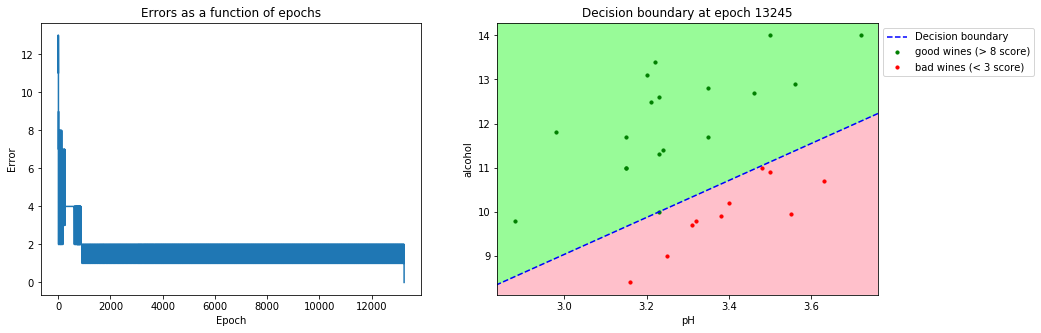

In [879]:
plot_performace(performance, data, target, 8, 3, -1, True)

## d) modify the red wine data to help the perceptron learn more efficient

In [8]:
def getMean(xj):
    return sum(xj) / len(xj)

def getStdDev(xj):
    mu = getMean(xj)
    se = (xj - mu)**2
    sse = sum(se)
    return math.sqrt(sse / (len(xj) - 1))

def standardization(data):
    new = pd.DataFrame()
    for col in range(data.shape[1]):
        xj = data.iloc[:,col].values
        std_xj = (xj - getMean(xj)) / getStdDev(xj)
        new[data.columns[col]] = std_xj
    return new

def meanNormalization(data):
    new = pd.DataFrame()
    for col in range(data.shape[1]):
        xj = data.iloc[:,col].values
        xj_min = min(xj)
        xj_max = max(xj)
        xj_mean = getMean(xj)
        new[data.columns[col]] = (xj - xj_mean) / (xj_max - xj_min)
    return new

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


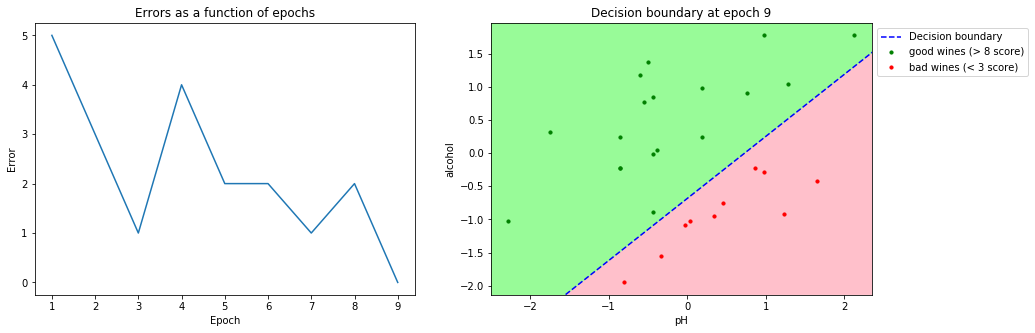

In [10]:
data = build_data("winequality-red.csv", 'pH', 'alcohol', 8, 3)
target = build_target("winequality-red.csv", 8, 3)
std_data = standardization(data)
precep = Perceptron(1, 0)
performance = precep.train(std_data.values, target.values, verbose=False)
plot_performace(performance, std_data, target, 8, 3, -1, True)

# Referance
## Perceptron

Perceptron basic: https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53<br>
Perceptron algorithm: https://towardsdatascience.com/perceptron-learning-algorithm-d5db0deab975<br>
19-line Line-by-line Python Perceptron: https://medium.com/@thomascountz/19-line-line-by-line-python-perceptron-b6f113b161f3<br>
The Perception Learning Rule - Tutorial: http://uni-obuda.hu/users/fuller.robert/perception.pdf<br>

## Python

Find the Angle Between Two Vectors: https://www.wikihow.com/Find-the-Angle-Between-Two-Vectors<br>
law of cosines: https://www.mathopenref.com/lawofcosinesproof.html<br>
Pandas Data Selection: https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/<br>
loading, editing, and viewing data: https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/<br>
iter row in DataFrame: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas<br>
pandas iteration: https://www.tutorialspoint.com/python_pandas/python_pandas_iteration.htm<br>
Joining DataFrames in Pandas: https://www.datacamp.com/community/tutorials/joining-dataframes-pandas<br>

## Plot

Graph plotting: https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/<br>
Plot Straight line: https://scriptverse.academy/tutorials/python-matplotlib-plot-straight-line.html<br>
Legend guide: https://matplotlib.org/tutorials/intermediate/legend_guide.html<br>

## Doc

pandas insert: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.insert.html<br>
pandas.DataFrame: https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.html<br>
pandas.DataFrame.drop: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html<br>
pandas.DataFrame.dot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dot.html<br>
pandas.DataFrame.add: http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.add.html<br>

# V.3 My fair ADALINE

## a) Marvin notices and chides you for torturing your perceptron. Why?
Frank Rosenblatt proved mathematically that the perceptron learning rule converges if the two classes can be separated by a linear hyperplane. However, if classes cannot be separated perfectly by such a linear decision boundary, the weights will never stop updating unless we set a maximum number of epochs.

## b) & C) implement ADALINE

In [9]:
class Adaline(ANN):
    
    def __init__(self, lr, epoch):
        ANN.__init__(self)
        self.lr = lr
        if (epoch <= 0):
            epoch = sys.maxsize
        self.epoch = epoch
    
    def train(self, data, target, verbose=True, online=False):
        curEpoch = 0
        performance = []
        self.weight = [0.0001 * random.uniform(-1, 1) for i in range(data.shape[1] + 1)]
        # Start training
        for _ in range(self.epoch):
            net_epoch = []
            error_epoch = []
            errorNumber = 0
            # update weight by batch
            for xi, yi in zip(data, target):
                netInput = self.net_input(xi)
                error = yi - netInput
                error_epoch.append(error[0])
                net_epoch.append(netInput)
                if (online == True):
                    self.weight[0] += self.lr * error
                    self.weight[1:] += self.lr * (xi * error)
            if (online == False):
                self.weight[0] += self.lr * sum(error_epoch)
                self.weight[1:] += self.lr * self.ft_dataTDotError(self.ft_transpose(data), error_epoch)
            # calculate cost
            for i in range(len(error_epoch)):
                error_epoch[i] = error_epoch[i] ** 2
            cost = sum(error_epoch) / 2
            # record performance
            errorNumber = self.errorCount(net_epoch, target);
            curEpoch += 1
            performance.append((curEpoch, errorNumber, self.weight, cost))
            if (verbose == True):
                print(f"Training Adaline, curEpoch: {curEpoch}, errorNumber: {errorNumber}")      
            if (self.epoch == sys.maxsize and self.isConverge(curEpoch, performance) == True):
                break
        return performance
    
    def isConverge(self, curEpoch, performance):
        if (curEpoch > 2 and performance[-2][3] - performance[-1][3] < 0.001):
            return True
        return False
    
    def net_input(self, x):
        return self.getNetValue(x, self.weight[1:]) + self.weight[0]

    def activation(self, x):
        return self.net_input(x)
    
    def errorCount(self, net, target):
        count = 0
        for i in range(len(net)):
            if ((target[i] >= 0 and net[i] < 0) or (target[i] < 0 and net[i] >= 0)):
                count += 1
        return count

In [10]:
data = build_data("winequality-red.csv", 'pH', 'alcohol', 7, 4)
target = build_target("winequality-red.csv", 7, 4, value=[1, -1])

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


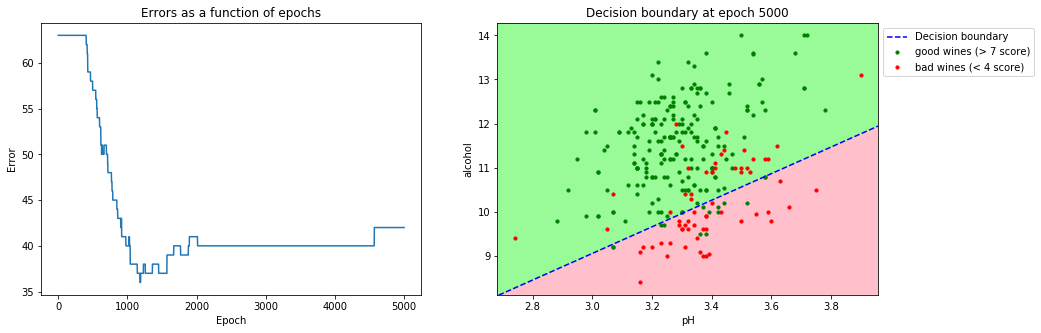

In [17]:
ada1 = Adaline(0.00005, 5000)
performance = ada1.train(data.values, target.values, verbose=False, online=False)
plot_performace(performance, data, target, 7, 4, -1, save_plot=True)

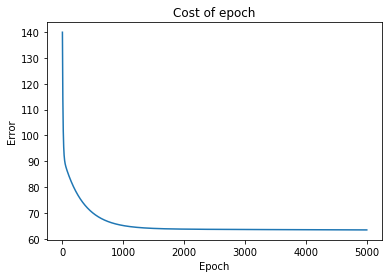

In [18]:
draw_cost_plot(performance, data, -1, save_plot=False)

## d) Find a good learning rate for your ADALINE

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


KeyboardInterrupt: 

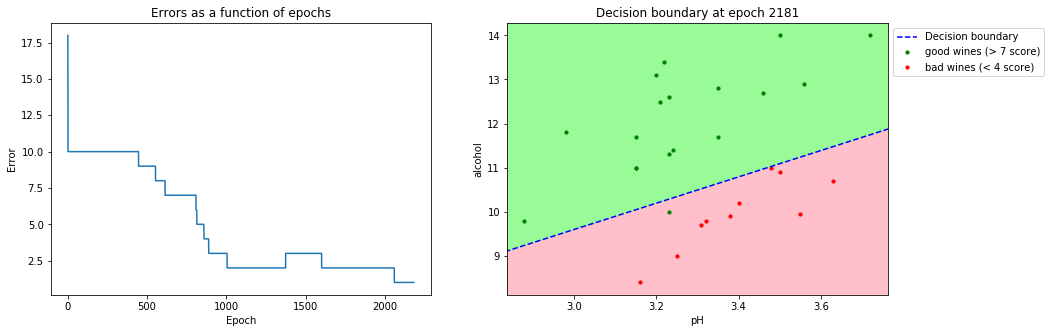

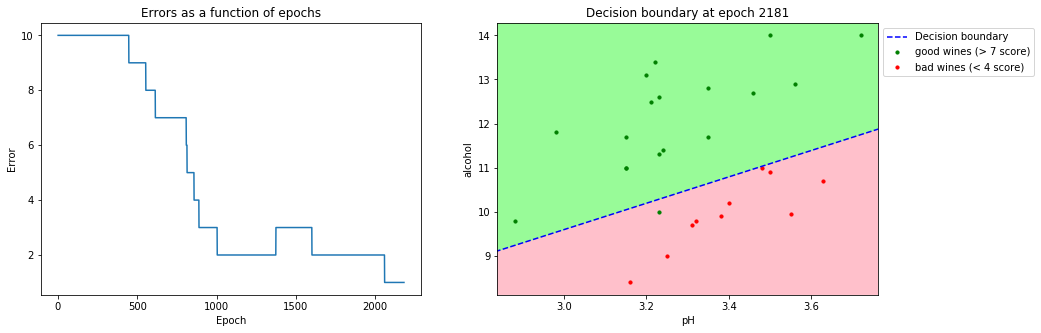

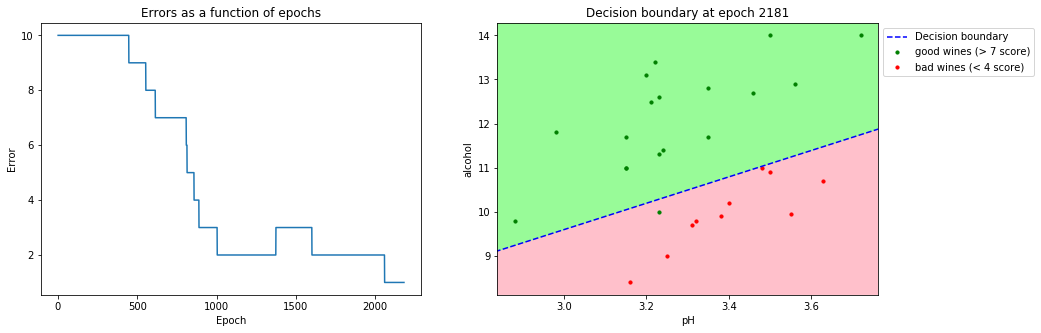

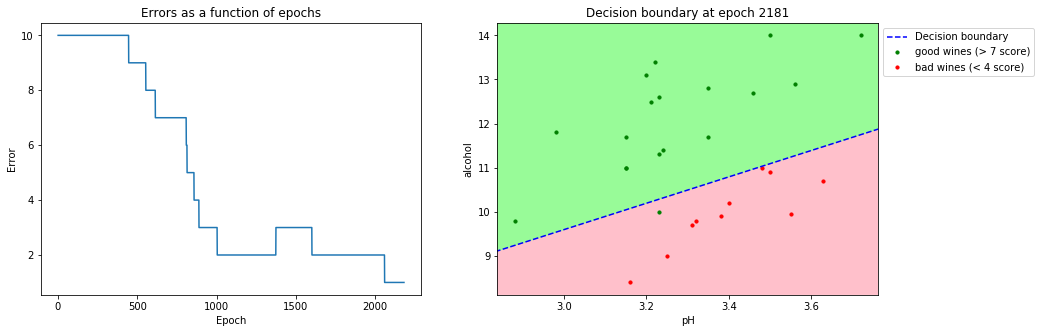

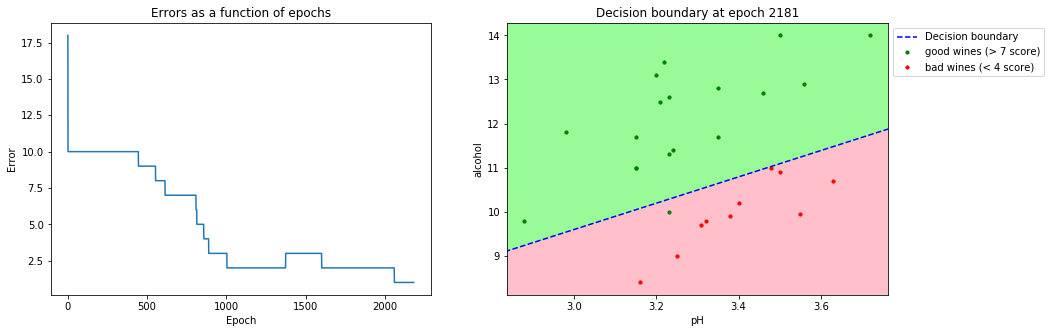

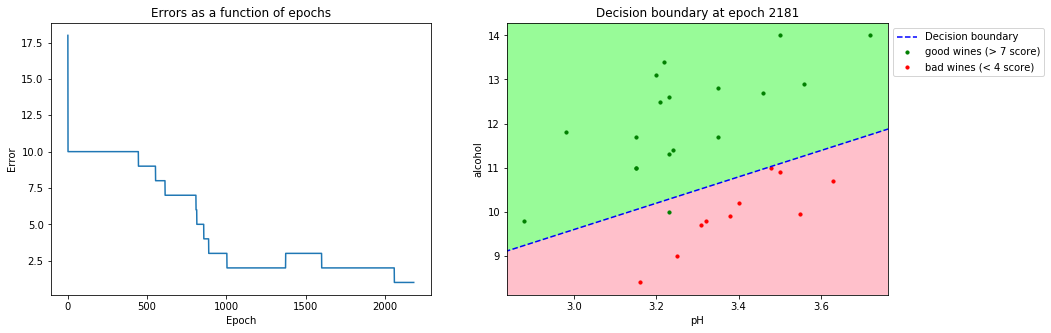

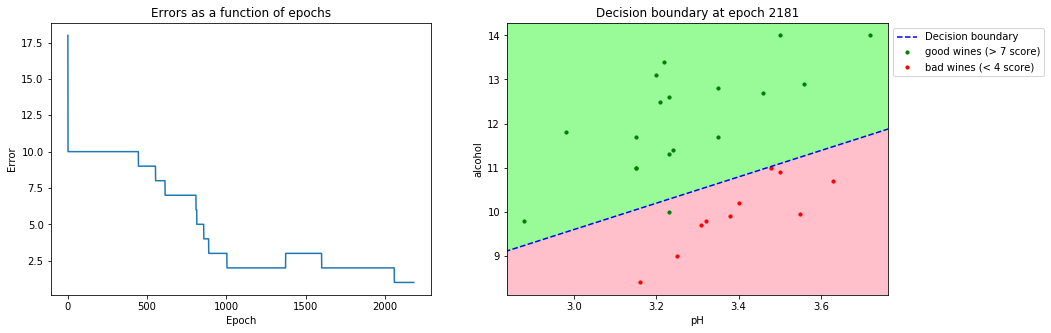

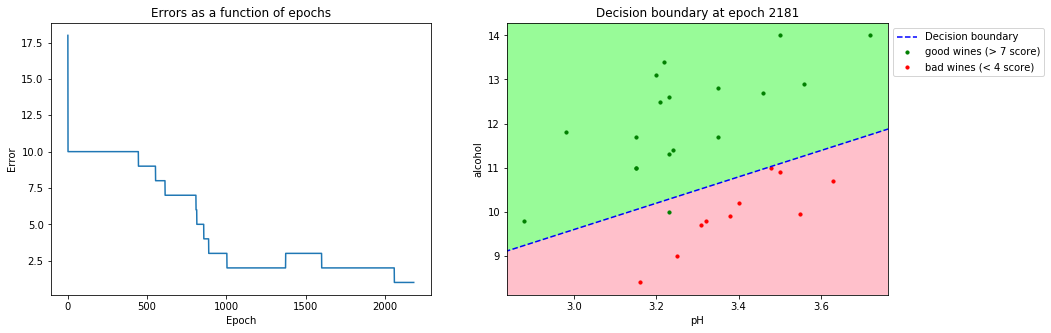

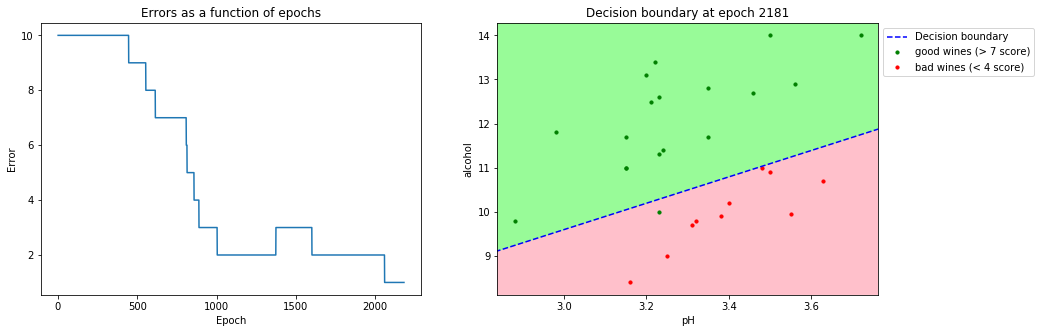

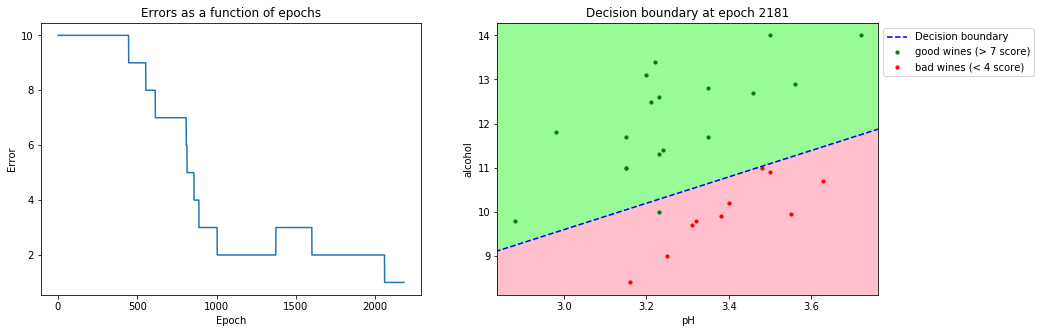

In [91]:
lr = 0.0001
for i in range(10):
        lr += 0.0001
        ada = Adaline(lr, 0)
        performance = ada1.train(data.values, target.values, verbose=False, online=False)
        plot_performace(performance, data, target, 7, 4, -1, save_plot=True)

# V.4 Advanced wine sampling and resampling

# Referance
Perceptron, Adaline, and neural network: https://sebastianraschka.com/faq/docs/diff-perceptron-adaline-neuralnet.html<br>
Gradient Descent Rule for Linear Regression and Adaline: http://rasbt.github.io/mlxtend/user_guide/general_concepts/linear-gradient-derivative/<br>
Gradient Descent and Stochastic Gradient Descent: http://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization/<br>
機器學習(3)--適應線性神經元與梯度下降法(Adaline neuron and Gradient descent): http://arbu00.blogspot.com/2017/02/3-adaline-neuron-and-gradient-descent.html<br>
The "Python Machine Learning (1st edition)" book code repository and info resource: https://github.com/rasbt/python-machine-learning-book<br>
人工神經網路(1)--使用Python實作perceptron(感知器): http://arbu00.blogspot.com/2016/11/1-pythonperceptron.html<br>
機器學習(4)--資料標準常態化與隨機梯度下降法( standardization & Stochastic Gradient descent): http://arbu00.blogspot.com/2017/02/4-standardization-stochastic-gradient.html<br>
Gradient Descent in a Nutshell: https://towardsdatascience.com/gradient-descent-in-a-nutshell-eaf8c18212f0<br>